In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50 ,DenseNet121, EfficientNetB7,VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, EarlyStopping
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
df = pd.read_csv('sufffle_image.csv')
df["category"] = df["category"].replace({0: 'Normal', 1: 'COVID-19', 2: 'Viral Pneumonia'})

In [4]:
df['category'].value_counts()

category
Normal             11561
Viral Pneumonia    11352
COVID-19           10988
Name: count, dtype: int64

<Axes: xlabel='category'>

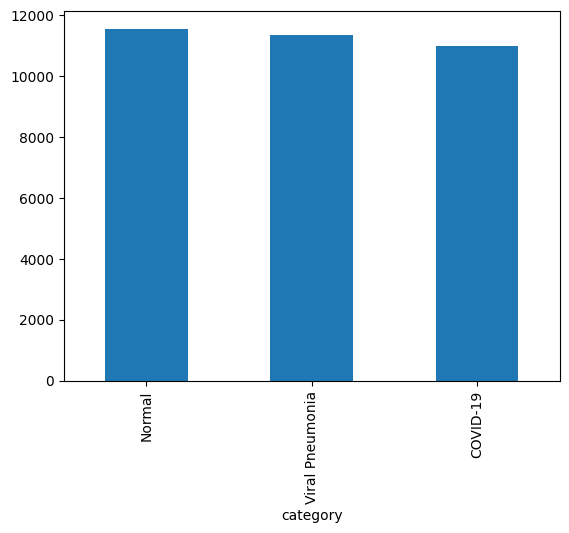

In [5]:
df['category'].value_counts().plot.bar()

In [6]:
# Divide the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
validate_df,test_df = train_test_split(val_df, test_size=0.50, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [7]:
# Set your IMAGE_SIZE and other parameters
IMAGE_SIZE = (180,180)
batch_size = 16

In [8]:
#Create data generators
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     rescale=1./255,
#     shear_range=0.1,
#     # zoom_range=0.2,
#     horizontal_flip=True,
    
#     brightness_range=[0.5, 1.5],
#     channel_shift_range=0.2,
#     vertical_flip=True,
#     preprocessing_function=lambda x: x + 0.01 * np.random.randn(*x.shape),
#     # random_rotation=30,
#     height_shift_range=0.1,
#     width_shift_range=0.1,
#     zoom_range=[0.8, 1.2],
#     # Exclude unsupported parameter
# )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=None,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
      batch_size=batch_size
)
   

Found 27120 validated image filenames belonging to 3 classes.
Found 3390 validated image filenames belonging to 3 classes.


In [9]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name="custom_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

In [10]:
custom_loss = CustomLoss()

In [11]:
model = load_model('radiography_ds.h5',custom_objects={'CustomLoss': CustomLoss})

In [12]:
model.compile(optimizer=Adam(lr=0.001), loss=custom_loss, metrics=['accuracy'])

c:\Users\Iftek\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 180, 180, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        9248      
                                                             

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'accuracy', 
                                            patience = 2, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.000001)
earlystop = EarlyStopping(
    monitor='val_loss',  # You can change this to another metric like 'val_accuracy'
    patience=10,  # Wait for 10 epochs to see if overfitting is resolved
    restore_best_weights=True,
    verbose=1
)
callbacks = [earlystop, learning_rate_reduction]

In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [16]:
# Fit the model
epochs = 100

# history = model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate // batch_size,
#     steps_per_epoch=total_train // batch_size,
#     callbacks=callbacks
# )
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)

Epoch 1/100
1695/1695 [==============================] - 267s 153ms/step - loss: 0.0282 - accuracy: 0.9485 - val_loss: 0.0249 - val_accuracy: 0.9479 - lr: 0.0010
Epoch 2/100
1695/1695 [==============================] - 247s 146ms/step - loss: 0.0254 - accuracy: 0.9531 - val_loss: 0.0601 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 3/100
1695/1695 [==============================] - 250s 147ms/step - loss: 0.0288 - accuracy: 0.9462 - val_loss: 0.0189 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 4/100
1695/1695 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9493
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1695/1695 [==============================] - 248s 146ms/step - loss: 0.0276 - accuracy: 0.9493 - val_loss: 0.0240 - val_accuracy: 0.9568 - lr: 0.0010
Epoch 5/100
1695/1695 [==============================] - 249s 147ms/step - loss: 0.0224 - accuracy: 0.9587 - val_loss: 0.0170 - val_accuracy: 0.9683 - lr: 5.0000e-04
Epoch 6/100
1695/1695 [

In [17]:
model.save('heuristic_Merged.h5')

In [18]:
model.get_weights()

[array([[[[ 8.90291929e-02, -4.60820138e-01,  1.53069451e-01,
           -5.89164086e-02,  6.67544454e-02, -3.78407598e-01,
            6.49680674e-01, -4.16868813e-02, -9.46107656e-02,
           -2.07627341e-01, -1.16024745e+00,  5.89987077e-02,
           -4.96464707e-02,  1.21636838e-01, -3.99818897e-01,
           -1.80009842e-01],
          [ 5.60559370e-02, -5.61094403e-01, -1.39342800e-01,
           -3.05688143e-01, -9.43451375e-02, -3.82328779e-01,
            6.27254546e-01, -1.17988296e-01, -1.13423586e-01,
           -1.79850310e-01, -1.34005606e+00, -2.22585082e-01,
            1.04956701e-01,  1.66025937e-01, -3.06408226e-01,
           -3.64515454e-01],
          [-1.28294468e-01, -7.12127268e-01,  1.32425755e-01,
           -1.81567490e-01,  9.43211168e-02, -3.65829259e-01,
            4.64605570e-01, -5.97087741e-02,  1.09158546e-01,
           -8.75779986e-02, -1.14589322e+00,  7.92286620e-02,
           -5.35265952e-02, -8.28382969e-02, -1.67977631e-01,
           -

In [19]:
actual_epochs = len(history.history['loss'])

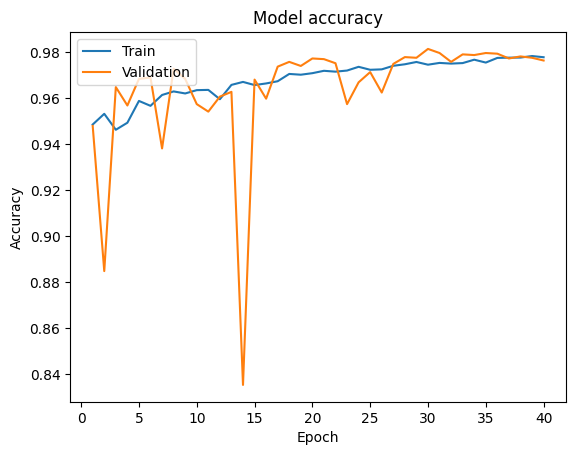

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
numEpochs = range(1,  actual_epochs + 1)
plt.plot(numEpochs,history.history['accuracy'])
plt.plot(numEpochs,history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

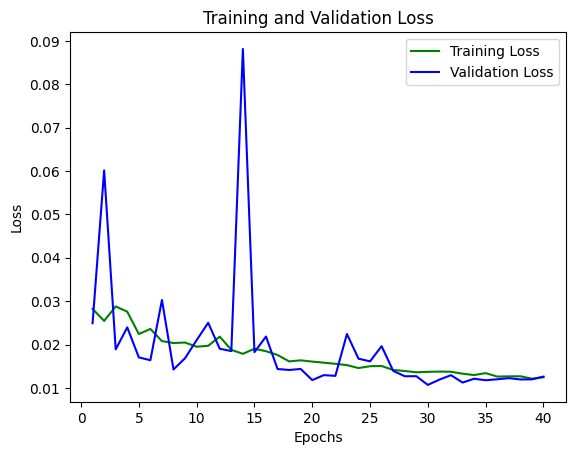

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
numEpochs = range(1,  actual_epochs + 1)
plt.plot( numEpochs,loss, 'g', label='Training Loss')
plt.plot(numEpochs,val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,filename,category
0,CL+MEDIAN\Pneumonia\Viral Pneumonia\images\CLA...,Viral Pneumonia
1,HE\Pneumonia\Viral Pneumonia\images\HE-person1...,Viral Pneumonia
2,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
3,Datasets\COVID-19_Radiography_Dataset\Viral Pn...,Viral Pneumonia
4,CS+MEDIAN\COVID-19_Radiography_Dataset\COVID\i...,COVID-19
...,...,...
3386,Datasets\COVID-19_Radiography_Dataset\COVID\im...,COVID-19
3387,HE\Pneumonia\Viral Pneumonia\images\HE-person2...,Viral Pneumonia
3388,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal
3389,Datasets\COVID-19_Radiography_Dataset\Normal\i...,Normal


In [23]:
nb_samples = test_df.shape[0]

In [24]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(    
    test_df, 
    directory=None,
    x_col='filename',
    y_col='category',
    target_size = IMAGE_SIZE,
    
    class_mode='categorical',
    batch_size = batch_size,
    shuffle = False,
)

Found 3391 validated image filenames belonging to 3 classes.


In [25]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

C:\Users\Iftek\AppData\Local\Temp\ipykernel_16024\2670138283.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


In [26]:
test_df['predict_category'] = np.argmax(predict, axis=-1)

In [27]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predict_category'] = test_df['predict_category'].replace(label_map)

In [28]:
test_df['predict_category'] = test_df['predict_category'].replace({'Normal': 0, 'COVID-19': 1, 'Viral Pneumonia': 2})

In [29]:
sample_test = test_df
correctPredictions = 0

correctNormalPred = 0
correctCovidPred = 0
correctPneuPred = 0

totalNormalPred = 0
totalCovidPred = 0
totalPneuPred = 0

for index, row in sample_test.iterrows():
    
    filename = row['filename']
    prediction = row['predict_category']
    
    # img = load_img(filename, target_size=IMAGE_SIZE)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    # print(third_phrase)

    if 'Normal' in third_phrase:
        
        if prediction == 0:
            correctPredictions += 1
            correctNormalPred += 1
            
        totalNormalPred += 1
    
    if 'COVID' in third_phrase:
        
        if prediction == 1: 
            correctPredictions += 1
            correctCovidPred += 1
            
        totalCovidPred += 1
    
    if 'Viral Pneumonia' in third_phrase:
        
        if prediction == 2: 
            correctPredictions += 1
            correctPneuPred += 1
            
        totalPneuPred += 1
    

In [30]:
print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
print('COVID-19 Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
print('Viral Pneumonia Predictions:', correctPneuPred, 'Accuracy', "{:.2%}".format(correctPneuPred / totalPneuPred))

Model Accuracy: 98.26%
Correct Predictions: 3332 Total Predictions: 3391

Normal Predictions: 1148 Accuracy 98.63%
COVID-19 Predictions: 1062 Accuracy 98.06%
Viral Pneumonia Predictions: 1122 Accuracy 98.08%


In [31]:
actual = []
pred = []

for row in test_df.iterrows():
    
    filename = row[1][0]
    # print(filename)
    path_parts = filename.split('\\')
    third_phrase = path_parts[2]
    if 'Normal' in third_phrase: actual.append(0)
    if 'COVID' in third_phrase: actual.append(1)
    if 'Viral Pneumonia' in third_phrase: actual.append(2)
    # print(f'Actual :{row[1][1]}')   
    # print(f'prediction :{row[1][2]}')   
    pred.append(row[1][2])

C:\Users\Iftek\AppData\Local\Temp\ipykernel_16024\4069215994.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0]
C:\Users\Iftek\AppData\Local\Temp\ipykernel_16024\4069215994.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred.append(row[1][2])


In [32]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [33]:
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1164
           1       0.99      0.98      0.99      1083
           2       0.99      0.98      0.99      1144

    accuracy                           0.98      3391
   macro avg       0.98      0.98      0.98      3391
weighted avg       0.98      0.98      0.98      3391



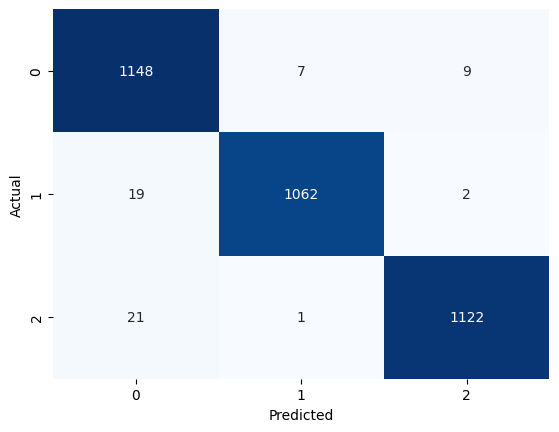

In [34]:
conf_matrix = confusion_matrix(actual, pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

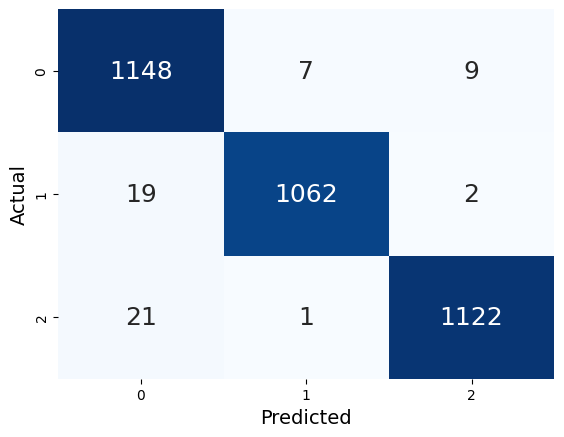

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = [[1148,7,9], [19,1062,2], [21,1,1122]]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize": 18})
plt.xlabel('Predicted', fontsize=14)  # Adjust the font size as needed
plt.ylabel('Actual', fontsize=14)  # Adjust the font size as needed
plt.savefig('cnn_heu.pdf')
plt.show()